In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pprint

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, log_loss, precision_score,\
    recall_score, roc_auc_score, roc_curve, confusion_matrix, auc, precision_recall_curve

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.precision', 3)

In [2]:
with open('zoospecphoto.pickle', 'rb') as f:
    zsp = pickle.load(f)
    f.close()
print(zsp.shape)
zsp.head()

(197937, 17)


,objid,specobjid,spiral,elliptical,ra,dec,redshift,u,g,r,i,z,spectroflux_u,spectroflux_g,spectroflux_r,spectroflux_i,spectroflux_z
0,1237666407365738659,432400020604479488,0,1,353.328,-0.450,0.058,16.977,15.068,14.146,13.695,13.355,34.103,116.890,291.053,438.653,588.161
1,1237671266033992047,327804855638845440,1,0,191.461,1.022,0.084,19.192,17.539,16.767,16.371,16.083,14.680,34.722,74.777,111.480,142.541
2,1237671266033926439,327806779784194048,1,0,191.382,0.902,0.090,19.660,18.034,17.142,16.661,16.288,7.395,20.238,48.781,79.235,108.319
3,1237674602679501105,340026473110857728,1,0,212.940,-0.904,0.054,19.379,17.573,16.585,16.073,15.599,7.780,24.795,65.689,112.534,161.226
4,1237648703516115180,340036093837600768,1,0,212.542,-0.752,0.107,18.453,17.116,16.507,16.141,15.884,7.553,17.453,35.027,52.075,65.697


In [25]:
def compute_metrics(model_fit, test_x, test_y):
    """
    Takes a classification model fit using sklearn, a test set
    prediction matrix, and the test set responses (labels), and 
    returns a dictionary with the computed accuracy, f1 score, 
    precision, recall, specificity (for binary response), 
    log-loss, and AUC score (for the ROC curve).
    
    Parameters
    -----------
    model_fit: sklearn classification model fit
    test_x: dataframe of predictor values for test data
    test_y: one-dimensional array or dataframe with test data labels
    
    Returns
    --------
    dictionary with seven calculated model evaluation metrics (six for 
    multiclass response)
    """
    
    pred = model_fit.predict(test_x)
    prob = model_fit.predict_proba(test_x)
    cm = confusion_matrix(test_y, model_fit.predict(test_x))
    
    acc = accuracy_score(test_y, pred)
    logloss = log_loss(test_y, prob)
    
    if test_y.nunique() > 2:
        f1 = f1_score(test_y, pred, average = 'weighted')
        prec = precision_score(test_y, pred, average = 'weighted')
        rec = recall_score(test_y, pred, average = 'weighted')
        auc = roc_auc_score(label_binarize(test_y, classes = list(model_fit.classes_)), 
                            prob, average = 'weighted')
        spec = np.nan
        
    else:
        f1 = f1_score(test_y, pred, average = 'binary')
        prec = precision_score(test_y, pred, average = 'binary')
        rec = recall_score(test_y, pred, average = 'binary')
        auc = roc_auc_score(test_y, prob[:,1])
        spec = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    
    return {'accuracy': acc, 'f1_score': f1, 'precision': prec, 
            'recall': rec, 'specificity': spec, 'log_loss': logloss, 
            'auc': auc}

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize = 18):
    """
    Takes a confusion matrix as returned by sklearn.metrics.confusion_matrix and returns it
    as a heatmap.
    
    Parameters
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order that they index the given confusion matrix.
    figsize: tuple
        A 2-tuple, the first value determining the horizontal size of the output figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axis labels. Defaults to 18.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix heatmap
    """
    
    df_cm = pd.DataFrame(confusion_matrix, index = class_names, columns = class_names, )
    plt.figure(figsize = figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot = True, fmt = "d", cmap = 'viridis')
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation = 0, 
                                 ha = 'right', fontsize = fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation = 45, 
                                 ha = 'right', fontsize = fontsize)
    plt.ylabel('True label', fontsize = 15, style = 'italic')
    plt.xlabel('Predicted label', fontsize = 15, style = 'italic')
    
    plt.show()
    plt.close()

In [4]:
X = zsp.iloc[:, 6:]
y = zsp['spiral']

# split train-test with stratified sampling (50/50 train/test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, 
                                                    random_state = 476, stratify = y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(98968, 11) (98969, 11) (98968,) (98969,)


In [5]:
# baseline ('dummy') classifier - always predicts 'Spiral'
dummy = DummyClassifier(strategy = 'most_frequent', random_state = 476).fit(X_train, y_train)
dummy_metrics = compute_metrics(dummy, X_test, y_test)
dummy_metrics

{'accuracy': 0.7360183491800463,
 'f1_score': 0.8479384443461457,
 'precision': 0.7360183491800463,
 'recall': 1.0,
 'specificity': 0.0,
 'log_loss': 9.117603210029772,
 'auc': 0.5}

### Logistic Regression

In [6]:
# scale predictors 
scale = StandardScaler().fit(X_train)
X_tr = scale.transform(X_train)
X_te = scale.transform(X_test)

# fit logistic regression model on training set with 'lbfgs' solver
logit = LogisticRegression(solver = 'lbfgs', random_state = 476).fit(X_tr, y_train)

# compute model evaluation metrics for model fit on test set
logit_metrics = compute_metrics(logit, X_te, y_test)
logit_metrics

{'accuracy': 0.9088401418626034,
 'f1_score': 0.9392122249322858,
 'precision': 0.9222361892160106,
 'recall': 0.9568249522946611,
 'specificity': 0.7750516726632474,
 'log_loss': 0.2612049191952878,
 'auc': 0.9473359102645225}

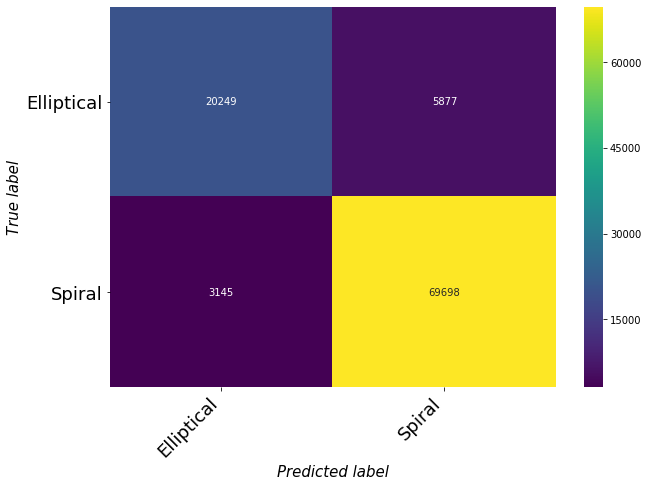

In [9]:
# compute confusion matrix and plot as heatmap
logit_cm = confusion_matrix(y_test, logit.predict(X_te), labels = logit.classes_)
print_confusion_matrix(logit_cm, ['Elliptical', 'Spiral'])

In [7]:
def roc_curve_binary(model, X, y):
    """
    Takes a binary classification model fit using sklearn, a prediction matrix, and a 
    response vector (labels), and returns an ROC curve with the AUC score shown in the 
    lower-right.
    
    Parameters
    -----------
    model: sklearn binary classification model fit
    X: dataframe of predictor values
    y: one-dimensional array or dataframe with labels
    
    Returns
    --------
    An ROC curve for the given model and data, with the AUC score shown in the lower-right
    legend. 
    """
    
    # Get predicted probabilities for test data
    prob = model.predict_proba(X)[:,1]
    
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y, prob)
    auc = np.round(roc_auc_score(y, prob), 3)
    
    # Plot ROC curve
    plt.figure(figsize = (10, 8))
    plt.plot(fpr, tpr, color = 'darkred', label = 'AUC: {}'.format(auc))
    plt.title("ROC Curve", fontsize = 18, 
              fontweight = 'bold', family = 'serif', y = 1.02)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', style = 'italic', fontsize = 15)
    plt.ylabel('True Positive Rate', style = 'italic', fontsize = 15)
    plt.xticks(fontsize = 12, rotation = 0)
    plt.yticks(fontsize = 12)
    plt.legend(loc = 'lower right')

    plt.show()
    plt.close()

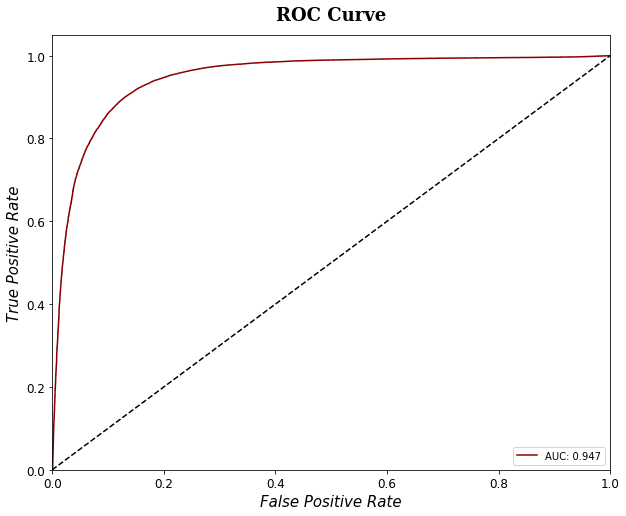

In [75]:
# plot ROC curve
roc_curve_binary(logit, X_te, y_test)

In [37]:
# print logistic regression coefficients
# since predictors were scaled, magnitude indicates predictor weight and sign indicates 
# direction of effect on probability of galaxy being spiral
pprint.pprint(X.columns)
pprint.pprint(logit.coef_)

Index(['redshift', 'u', 'g', 'r', 'i', 'z', 'spectroflux_u', 'spectroflux_g',
       'spectroflux_r', 'spectroflux_i', 'spectroflux_z'],
      dtype='object')
array([[ -1.1967537 , -28.03230148, -11.09622721,   0.748779  ,
          0.1261367 ,   0.38873363,  -0.74440664,  11.92635421,
        -29.69588511,  10.35983551,   6.45160504]])


### k-Nearest Neighbors

In [53]:
# use 10-fold CV on training set to find optimal k for kNN model
k_list = np.arange(1, 21)  # 20 different values of k
knn_acc = {}
knn_auc = {}

for k in k_list:
    # fit kNN model for each k, using 10-fold CV on training set to evaluate
    # compute accuracy and AUC for each fold for each k, and take average across folds
    knn = KNeighborsClassifier(n_neighbors = k)
    knn_acc[k] = np.mean(cross_val_score(knn, X_train, y_train, cv = 10, scoring = 'accuracy'))
    knn_auc[k] = np.mean(cross_val_score(knn, X_train, y_train, cv = 10, scoring = 'roc_auc'))

# compile results into dataframe with each value of k as columns
pd.DataFrame([knn_acc, knn_auc], index = ['accuracy', 'auc'])

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
accuracy,0.869554,0.860409,0.887933,0.886297,0.895006,0.893309,0.898058,0.895825,0.898755,0.897533,0.898594,0.897846,0.899028,0.898038,0.898897,0.898402,0.898705,0.897846,0.898361,0.897664
auc,0.829762,0.886284,0.909621,0.921095,0.928530,0.933006,0.936938,0.939417,0.941632,0.943141,0.944181,0.944738,0.945450,0.946234,0.946883,0.947224,0.947626,0.947829,0.948012,0.948167


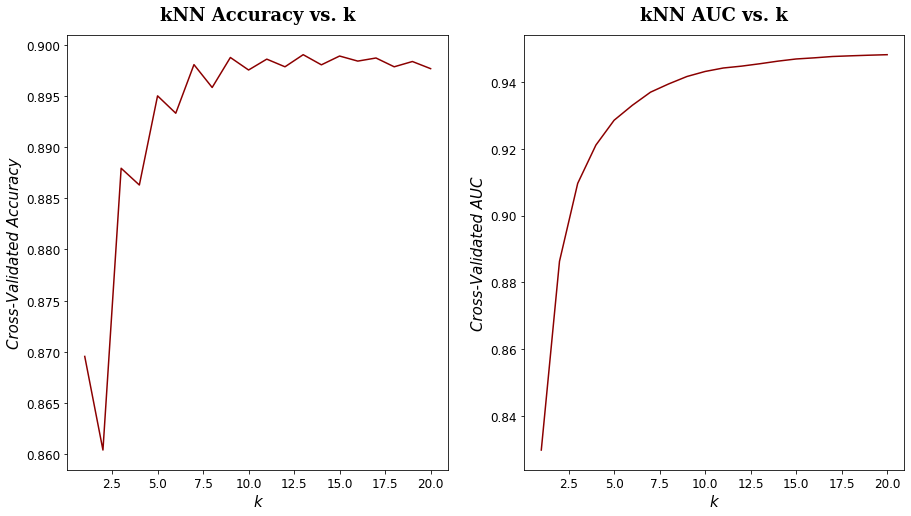

In [54]:
# plot CV accuracy and AUC vs. k
plt.figure(figsize = (15, 8))
plt.subplot(1, 2, 1)
plt.plot(k_list, list(knn_acc.values()), color = 'darkred')
plt.title("kNN Accuracy vs. k", fontsize = 18, fontweight = 'bold', family = 'serif', y = 1.02)
plt.xlabel('k', style = 'italic', fontsize = 15)
plt.ylabel('Cross-Validated Accuracy', style = 'italic', fontsize = 15)
plt.xticks(fontsize = 12, rotation = 0)
plt.yticks(fontsize = 12)

plt.subplot(1, 2, 2)
plt.plot(k_list, list(knn_auc.values()), color = 'darkred')
plt.title("kNN AUC vs. k", fontsize = 18, fontweight = 'bold', family = 'serif', y = 1.02)
plt.xlabel('k', style = 'italic', fontsize = 15)
plt.ylabel('Cross-Validated AUC', style = 'italic', fontsize = 15)
plt.xticks(fontsize = 12, rotation = 0)
plt.yticks(fontsize = 12)

plt.savefig('knn_galaxy_cv.png', dpi = 100, bbox_inches = 'tight')
plt.show()
plt.close()

In [8]:
# scale predictors
scale = StandardScaler().fit(X_train)
X_tr = scale.transform(X_train)
X_te = scale.transform(X_test)

# fit kNN model to whole training set using optimal k
knn = KNeighborsClassifier(n_neighbors = 13).fit(X_tr, y_train)
knn_metrics = compute_metrics(knn, X_te, y_test)
knn_metrics

{'accuracy': 0.9173074397033415,
 'f1_score': 0.9444270911140386,
 'precision': 0.9344019993819115,
 'recall': 0.9546696319481625,
 'specificity': 0.8131363392788793,
 'log_loss': 0.47027626749644535,
 'auc': 0.9562344661230366}

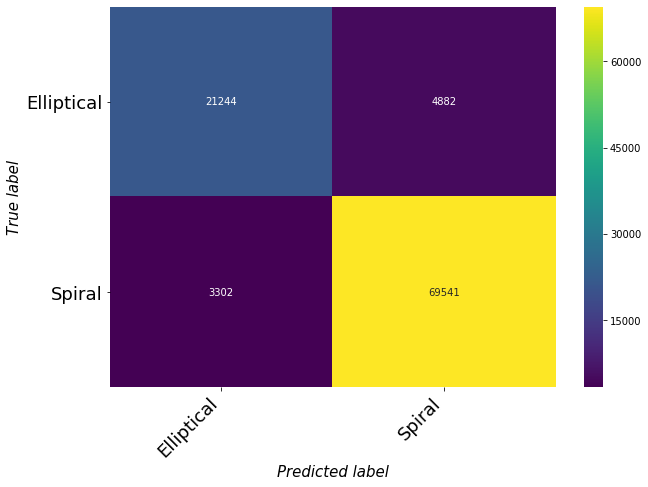

In [16]:
# kNN confusion matrix
knn_cm = confusion_matrix(y_test, knn.predict(X_te))
print_confusion_matrix(knn_cm, ['Elliptical', 'Spiral'])

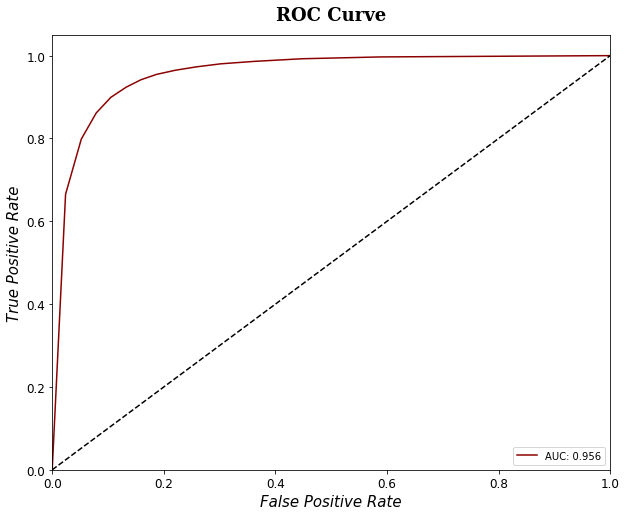

In [17]:
# plot ROC curve
roc_curve_binary(knn, X_te, y_test)

### Naive Bayes

In [9]:
# fit naive bayes classifier to training set and evaluate with test set
nb = GaussianNB().fit(X_train, y_train)
nb_metrics = compute_metrics(nb, X_test, y_test)
nb_metrics

{'accuracy': 0.6333195242954864,
 'f1_score': 0.6798863856888308,
 'precision': 0.9510154726945191,
 'recall': 0.5290556402125118,
 'specificity': 0.9240220470029855,
 'log_loss': 1.454470638258716,
 'auc': 0.8365999842473546}

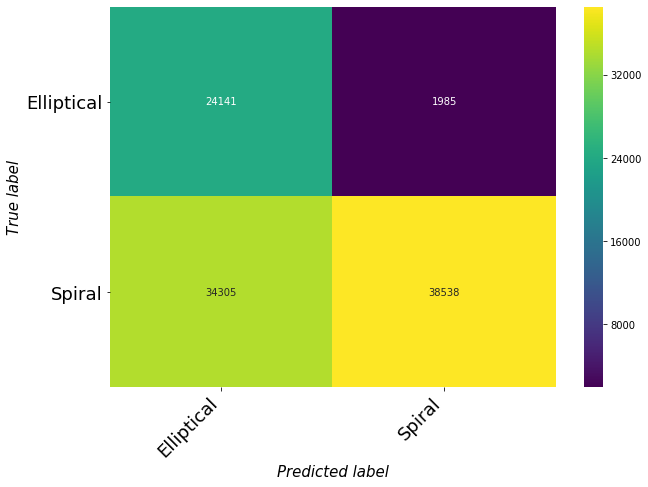

In [22]:
# naive bayes confusion matrix
nb_cm = confusion_matrix(y_test, nb.predict(X_test))
print_confusion_matrix(nb_cm, ['Elliptical', 'Spiral'])

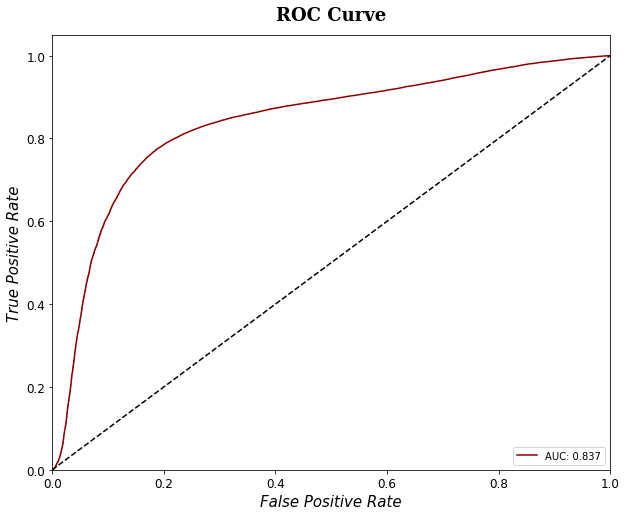

In [20]:
# plot ROC curve
roc_curve_binary(nb, X_test, y_test)

In [63]:
pprint.pprint(X.columns)
pprint.pprint(list(zip(['Elliptical', 'Spiral'], nb.theta_)))  # mean of each feature by class
pprint.pprint(list(zip(['Elliptical', 'Spiral'], np.sqrt(nb.sigma_))))  # variance of each feature by class

Index(['redshift', 'u', 'g', 'r', 'i', 'z', 'spectroflux_u', 'spectroflux_g',
       'spectroflux_r', 'spectroflux_i', 'spectroflux_z'],
      dtype='object')
[('Elliptical',
  array([1.36909557e-01, 1.96524912e+01, 1.76449179e+01, 1.65387181e+01,
       1.60772568e+01, 1.57330240e+01, 1.34896639e+01, 4.45959648e+01,
       1.12977130e+02, 1.69290483e+02, 2.22161383e+02])),
 ('Spiral',
  array([9.51739670e-02, 1.90785328e+01, 1.75240559e+01, 1.68734600e+01,
       1.64622659e+01, 1.61694664e+01, 9.69846496e+00, 2.53856892e+01,
       5.67062339e+01, 8.50408476e+01, 1.09675621e+02]))]
[('Elliptical',
  array([7.02967595e-02, 1.31724495e+00, 1.16811822e+00, 1.00116792e+00,
       9.71314759e-01, 9.60121700e-01, 1.54689678e+01, 5.04518951e+01,
       1.09833393e+02, 1.58760296e+02, 2.06376728e+02])),
 ('Spiral',
  array([4.13523813e-02, 3.71321338e+01, 3.71233115e+01, 8.05688412e-01,
       7.95915425e-01, 8.03126806e-01, 8.92182251e+00, 2.15844041e+01,
       4.69131309e+01, 6.95304596e+

### Support Vector Classifier

In [7]:
# split data again for SVM (train is now 10% of original data, val is 40%, and test is 50%)
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size = 0.8, 
                                                    random_state = 476, stratify = y_train)
print(X_train2.shape, X_val.shape, y_train2.shape, y_val.shape)

(19793, 11) (79175, 11) (19793,) (79175,)


In [8]:
# use train-test split to find optimal C for support vector classifier model
C_list = 10**np.linspace(-3, 2, 6)  # 6 different values of C covering 6 orders of magnitude
svc_acc = {}

for c in C_list:
    # for each C, fit linear SVC model on training set and predict on test set; calculate accuracy
    svc = svm.SVC(C = c, kernel = 'linear', random_state = 476).fit(X_train2, y_train2)
    svc_acc[c] = accuracy_score(y_val, svc.predict(X_val))
svc_acc

{0.001: 0.8932996526681402,
 0.01: 0.9001705083675403,
 0.1: 0.9084180612567099,
 1.0: 0.9115503631196716,
 10.0: 0.9098326491948217,
 100.0: 0.9066750868329649}

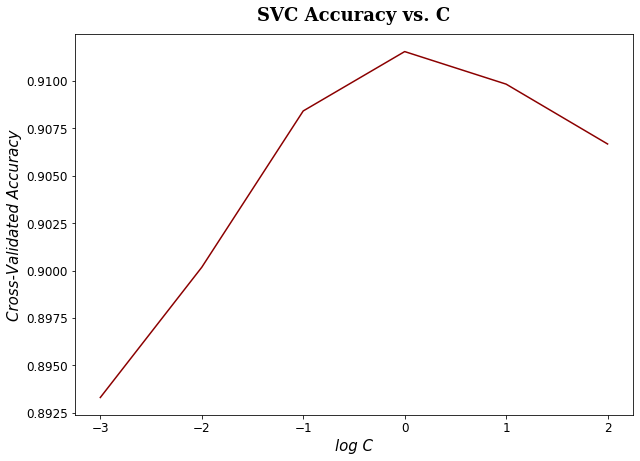

In [10]:
# plot accuracy vs. log of C
plt.figure(figsize = (10, 7))
plt.plot(np.log10(C_list), list(svc_acc.values()), color = 'darkred')
plt.title("SVC Accuracy vs. C", fontsize = 18, fontweight = 'bold', family = 'serif', y = 1.02)
plt.xlabel('log C', style = 'italic', fontsize = 15)
plt.ylabel('Cross-Validated Accuracy', style = 'italic', fontsize = 15)
plt.xticks(fontsize = 12, rotation = 0)
plt.yticks(fontsize = 12)

plt.show()
plt.close()

In [20]:
# scale predictors for full (original) training and test sets
scale = StandardScaler().fit(X_train)
X_tr = scale.transform(X_train)
X_te = scale.transform(X_test)

# fit linear SVC model to full training set and predict on full test set, using optimal C
svc = svm.SVC(C = 1, kernel = 'linear', random_state = 476, probability = True)\
    .fit(X_tr, y_train)
svc_metrics = compute_metrics(svc, X_te, y_test)
svc_metrics

{'accuracy': 0.9100526427467187,
 'f1_score': 0.939874101691252,
 'precision': 0.9250661454801696,
 'recall': 0.9551638455307991,
 'specificity': 0.7842761999540687,
 'log_loss': 0.2620891078007034,
 'auc': 0.9485319330816935}

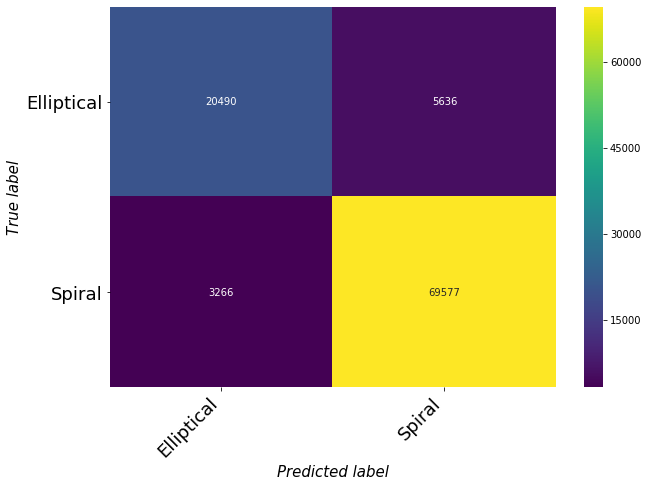

In [14]:
# SVC confusion matrix
svc_cm = confusion_matrix(y_test, svc.predict(X_te))
print_confusion_matrix(svc_cm, ['Elliptical', 'Spiral'])

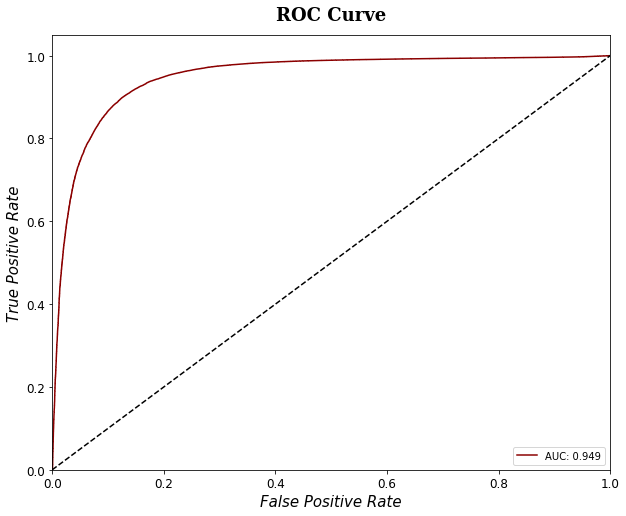

In [17]:
# plot ROC curve
roc_curve_binary(svc, X_te, y_test)

### Support Vector Machine (radial basis kernel)

In [28]:
# setup parameter grid for SVM model with radial basis function, varying C and gamma
rbf = svm.SVC(kernel = 'rbf', random_state = 476)
param_grid = dict(C = [0.01, 0.1, 1, 10],
                  gamma = [0.01, 0.1, 1])

# use grid search with CV on smaller training set to find optimal combination of parameter values
# mean accuracy across all folds used as scoring metric
grid = GridSearchCV(rbf, param_grid, cv = 5, scoring = 'accuracy')
grid.fit(X_train2, y_train2)

print(grid.best_score_)  # 90.1% accuracy
print(grid.best_params_)  # C = 1 and gamma = 0.01
print(grid.best_estimator_)

0.9011771838528773
{'C': 1, 'gamma': 0.01}
SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=476, shrinking=True, tol=0.001,
    verbose=False)


In [26]:
# scale predictors (full training and test sets)
scale = StandardScaler().fit(X_train)
X_tr = scale.transform(X_train)
X_te = scale.transform(X_test)

# fit SVM RBF model to full training set and predict on full test set using optimal C/gamma
rbf = svm.SVC(kernel = 'rbf', random_state = 476, C = 1, gamma = 0.01, probability = True)\
    .fit(X_tr, y_train)  # need probability = True here to compute evaluation metrics
rbf_metrics = compute_metrics(rbf, X_te, y_test)
rbf_metrics

{'accuracy': 0.9101435803130273,
 'f1_score': 0.9400922900737646,
 'precision': 0.9229385465992963,
 'recall': 0.9578957483903738,
 'specificity': 0.7770037510525913,
 'log_loss': 0.23365327554214518,
 'auc': 0.9534570035596592}

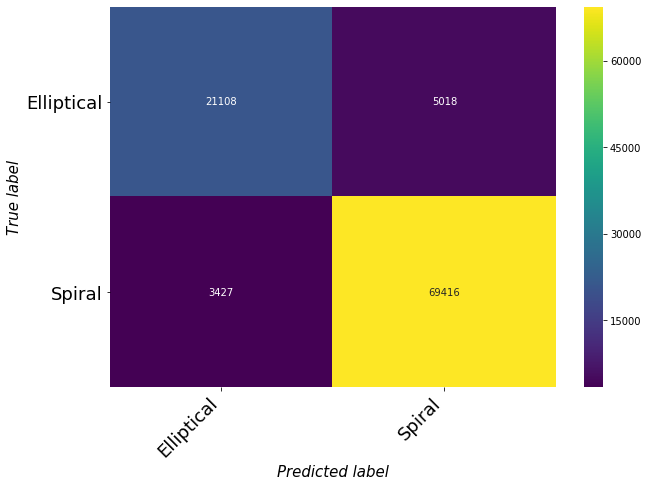

In [48]:
# SVM RBF confusion matrix
rbf_cm = confusion_matrix(y_test, rbf.predict(X_te))
print_confusion_matrix(rbf_cm, ['Elliptical', 'Spiral'])

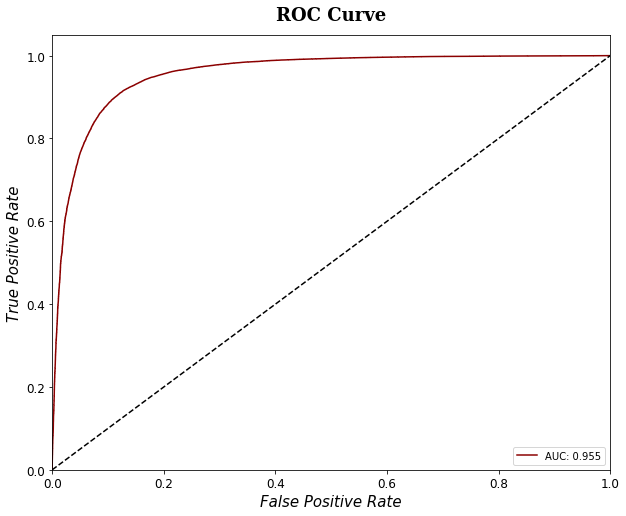

In [49]:
# plot ROC curve
roc_curve_binary(rbf, X_te, y_test)

### Decision Trees

In [9]:
# use grid search with CV on training set to find optimal combination of parameters
# parameters tested: max # of tree layers, min # of samples per leaf, max # of features tested per split
tree = DecisionTreeClassifier(random_state = 476)
param_grid = dict(max_depth = [10, 25, 50], 
                  min_samples_leaf = [10, 100, 1000], 
                  max_features = [None, 6]
                 )

# mean accuracy across all folds used as scoring metric
grid = GridSearchCV(tree, param_grid, cv = 5, scoring = 'accuracy')
grid.fit(X_train, y_train)

print(grid.best_score_)  # 91.43% accuracy
print(grid.best_params_)  # max depth = 10, max # of features = None, min # leaf samples = 10
print(grid.best_estimator_)

0.9142551127637216
{'max_depth': 10, 'max_features': None, 'min_samples_leaf': 10}
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=476, splitter='best')


In [10]:
# repeat grid search with new grid based on previous results
param_grid2 = dict(max_depth = [5, 10, 15], 
                   min_samples_leaf = [5, 10, 15]
                  )

grid2 = GridSearchCV(tree, param_grid2, cv = 5, scoring = 'accuracy')
grid2.fit(X_train, y_train)

print(grid2.best_score_)  # no substantial improvement in accuracy
print(grid2.best_params_)  # min # leaf samples changed to 5
print(grid2.best_estimator_)

0.9142652170398513
{'max_depth': 10, 'min_samples_leaf': 5}
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=476, splitter='best')


In [12]:
# repeat grid search with new grid based on previous results
param_grid3 = dict(max_depth = [8, 10, 12], 
                   min_samples_leaf = [3, 5, 7]
                  )

grid3 = GridSearchCV(tree, param_grid3, cv = 5, scoring = 'accuracy')
grid3.fit(X_train, y_train)

print(grid3.best_score_)  # 91.45% accuracy
print(grid3.best_params_)  # min # of leaf samples changed to 7
print(grid3.best_estimator_)

0.9145178239430927
{'max_depth': 10, 'min_samples_leaf': 7}
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=7, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=476, splitter='best')


In [10]:
# fit tree to full training set using optimal parameters and predict on full test set
tree = DecisionTreeClassifier(max_depth = 10, min_samples_leaf = 7, random_state = 476)\
    .fit(X_train, y_train)
tree_metrics = compute_metrics(tree, X_test, y_test)
tree_metrics

{'accuracy': 0.9162667097778092,
 'f1_score': 0.9435340451482342,
 'precision': 0.9366730701588246,
 'recall': 0.9504962728058977,
 'specificity': 0.8208298246957054,
 'log_loss': 0.31155658513284795,
 'auc': 0.9562331093865901}

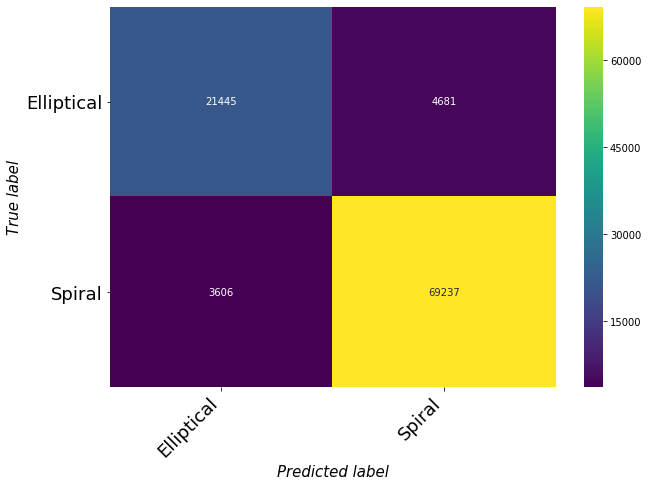

In [14]:
# classification decision tree confusion matrix
tree_cm = confusion_matrix(y_test, tree.predict(X_test))
print_confusion_matrix(tree_cm, ['Elliptical', 'Spiral'])

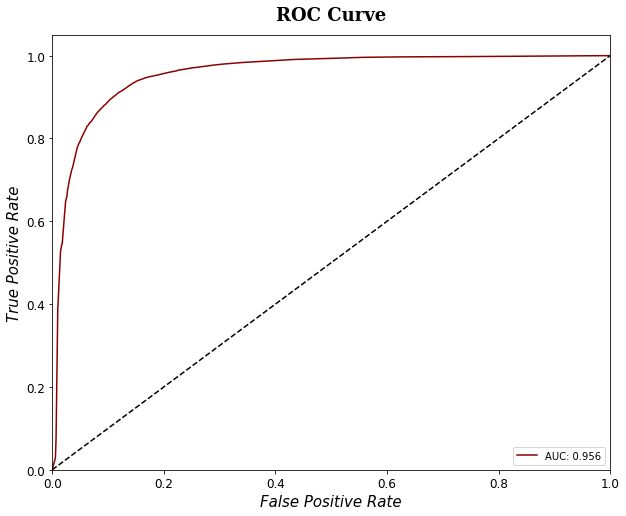

In [17]:
# plot ROC curve
roc_curve_binary(tree, X_test, y_test)

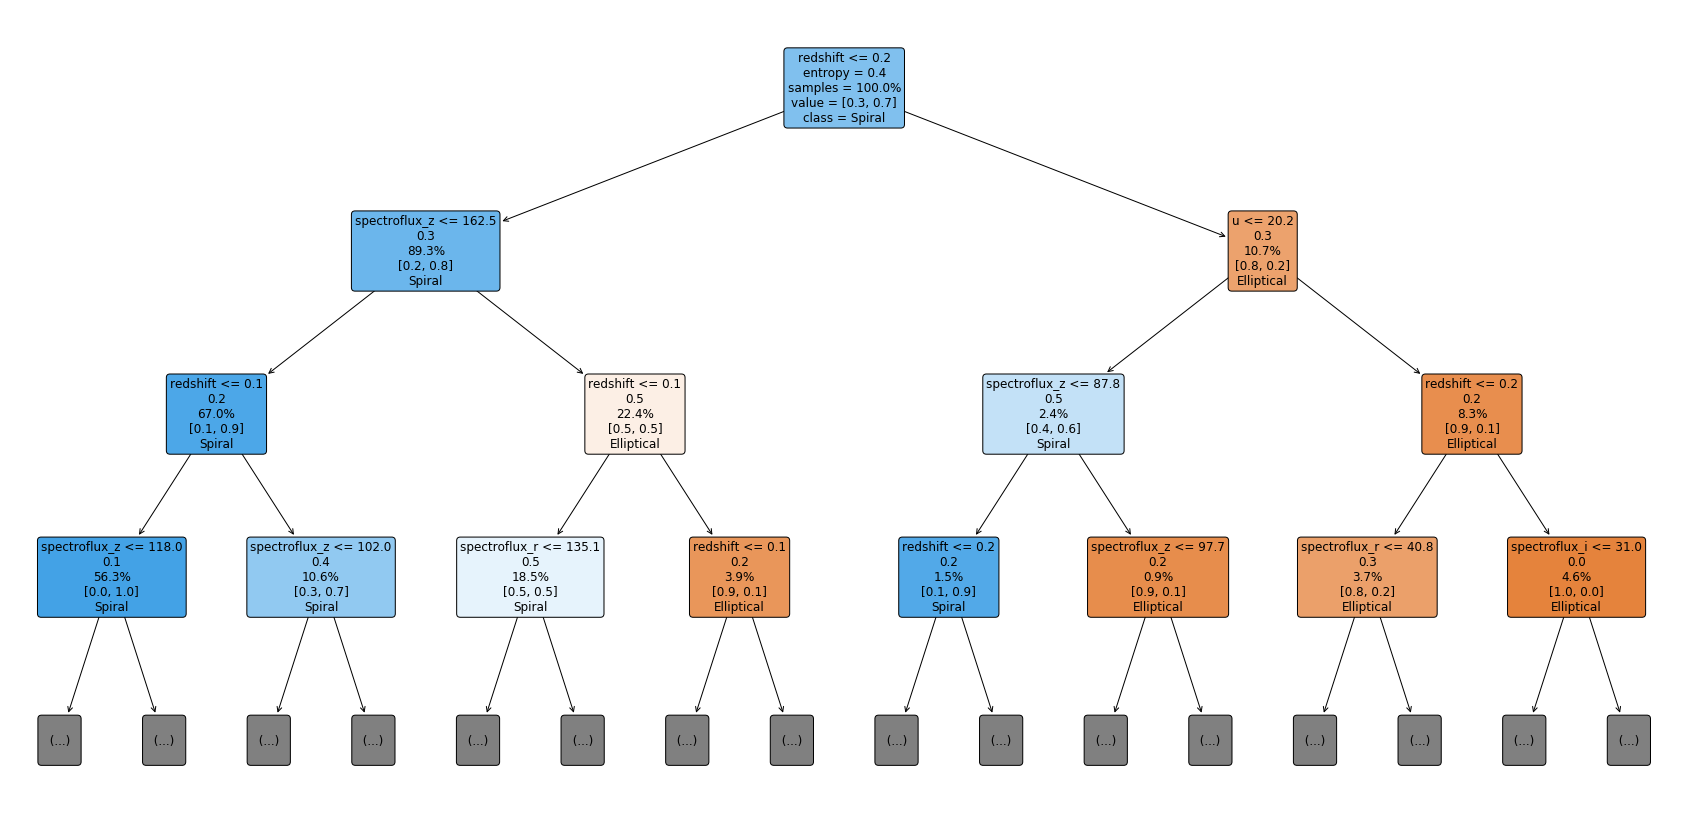

In [13]:
# plot decision tree showing split, entropy, % of samples, fraction in each branch, and class for each node
plt.figure(figsize = (30, 15))
plot_tree(tree, feature_names = list(X.columns), max_depth = 3,
          class_names = ['Elliptical', 'Spiral'], filled = True, proportion = True, 
          rounded = True, precision = 1, fontsize = 12, label = 'root')

plt.savefig('tree_galaxy.png', dpi = 100, bbox_inches = 'tight')
plt.show()
plt.close()

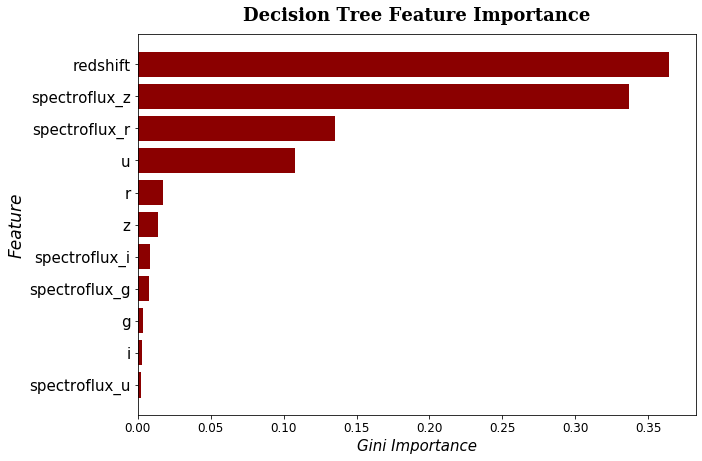

In [17]:
# bar plot of Gini importance for each predictor
feature_imp = pd.DataFrame({'features': X.columns, 'importance': tree.feature_importances_})\
                    .sort_values('importance', ascending = True)

plt.figure(figsize = (10, 7))
plt.barh(feature_imp['features'], feature_imp['importance'], color = 'darkred')
plt.title("Decision Tree Feature Importance", fontsize = 18, 
          fontweight = 'bold', family = 'serif', y = 1.02)
plt.xlabel("Gini Importance", fontsize = 15, style = 'italic')
plt.ylabel("Feature", fontsize = 17, style = 'italic')
plt.xticks(fontsize = 12, rotation = 0)
plt.yticks(fontsize = 15)

plt.savefig('tree_galaxy_importance.png', dpi = 100, bbox_inches = 'tight')
plt.show()
plt.close()

### Bagging and Random Forest

In [15]:
# fit bagging ensemble model to full training set and predict on test set
# using 'max_features = None' with RandomForestClassifier equivalent to bagging
bag = RandomForestClassifier(n_estimators = 500, max_features = None, 
                            random_state = 476, oob_score = True)
bag.fit(X_train, y_train)
bag_metrics = compute_metrics(bag, X_test, y_test)
bag_metrics

{'accuracy': 0.9273711970414978,
 'f1_score': 0.9511558690422799,
 'precision': 0.9417107334598152,
 'recall': 0.9607923891108274,
 'specificity': 0.834188165046314,
 'log_loss': 0.19378090741362455,
 'auc': 0.9723119945268055}

In [16]:
# fit random forest model to full training set and predict on test set
# fit a total of 500 trees and randomly select 3 features to choose from at each split
rf = RandomForestClassifier(n_estimators = 500, max_features = 3, 
                            random_state = 476, oob_score = True)
rf.fit(X_train, y_train)
rf_metrics = compute_metrics(rf, X_test, y_test)
rf_metrics

{'accuracy': 0.927755155654801,
 'f1_score': 0.9514859546749899,
 'precision': 0.9406737593409984,
 'recall': 0.962549592960202,
 'specificity': 0.8307433208298247,
 'log_loss': 0.18254536717318112,
 'auc': 0.9736199859338904}

In [40]:
# random forest slightly outperformed bagging
print(bag.oob_score_, rf.oob_score_)

0.9282798480316871 0.929047773017541


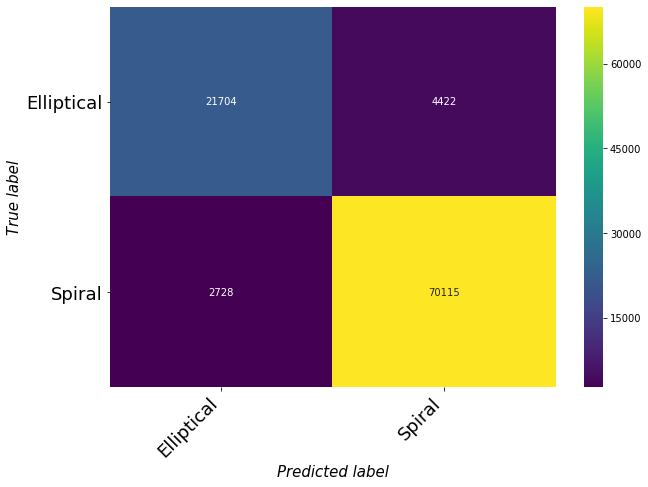

In [24]:
# random forest confusion matrix
rf_cm = confusion_matrix(y_test, rf.predict(X_test))
print_confusion_matrix(rf_cm, ['Elliptical', 'Spiral'])

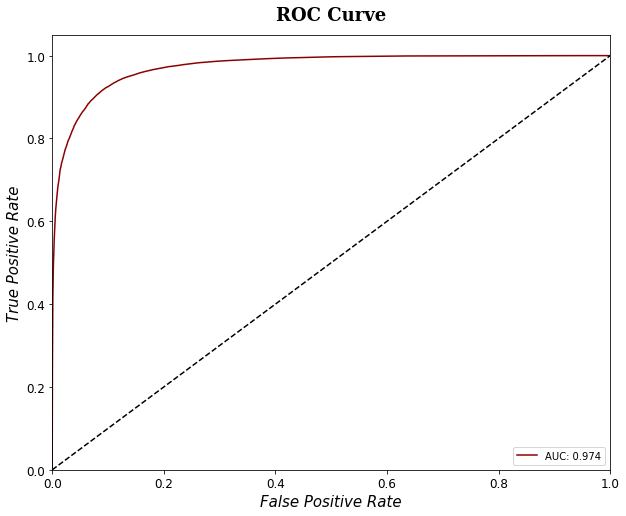

In [43]:
# plot random forest ROC curve
roc_curve_binary(rf, X_test, y_test)

In [44]:
# Gini importance for each predictor
dict(zip(X.columns, np.round(rf.feature_importances_, 4)))

{'redshift': 0.2758,
 'u': 0.122,
 'g': 0.0686,
 'r': 0.0418,
 'i': 0.0406,
 'z': 0.0421,
 'spectroflux_u': 0.0384,
 'spectroflux_g': 0.0573,
 'spectroflux_r': 0.0986,
 'spectroflux_i': 0.0933,
 'spectroflux_z': 0.1216}

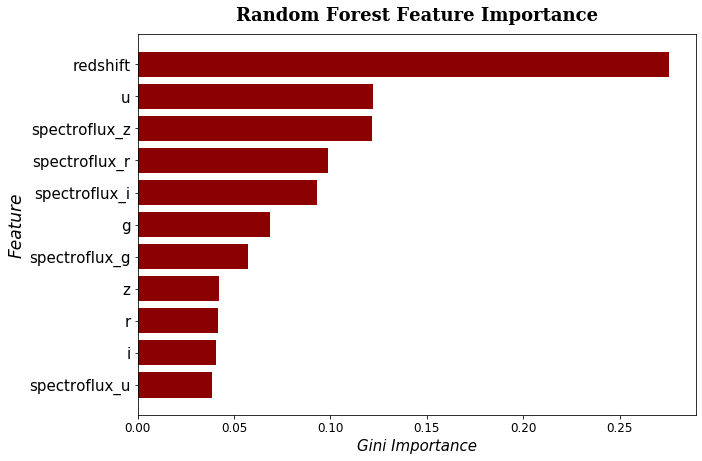

In [18]:
# bar plot of Gini importance for each predictor
feature_imp_rf = pd.DataFrame({'features': X.columns, 'importance': rf.feature_importances_})\
                    .sort_values('importance', ascending = True)

plt.figure(figsize = (10, 7))
plt.barh(feature_imp_rf['features'], feature_imp_rf['importance'], color = 'darkred')
plt.title("Random Forest Feature Importance", fontsize = 18, 
          fontweight = 'bold', family = 'serif', y = 1.02)
plt.xlabel("Gini Importance", fontsize = 15, style = 'italic')
plt.ylabel("Feature", fontsize = 17, style = 'italic')
plt.xticks(fontsize = 12, rotation = 0)
plt.yticks(fontsize = 15)

plt.savefig('rf_galaxy_importance.png', dpi = 100, bbox_inches = 'tight')
plt.show()
plt.close()

### Compare Models

In [27]:
# compile evaluation metrics for all models into dataframe
model_metrics = pd.DataFrame([dummy_metrics, logit_metrics, knn_metrics, 
                              nb_metrics, svc_metrics, rbf_metrics, tree_metrics, 
                              bag_metrics, rf_metrics], 
                             index = ['dummy', 'logit', 'knn', 'naive_bayes', 'svc', 
                                      'svm_rbf', 'dec_tree', 'bagging', 'random_forest'])
model_metrics

,accuracy,auc,f1_score,log_loss,precision,recall,specificity
dummy,0.736,0.500,0.848,9.118,0.736,1.000,0.000
logit,0.909,0.947,0.939,0.261,0.922,0.957,0.775
knn,0.917,0.956,0.944,0.470,0.934,0.955,0.813
naive_bayes,0.633,0.837,0.680,1.454,0.951,0.529,0.924
svc,0.910,0.949,0.940,0.262,0.925,0.955,0.784
svm_rbf,0.910,0.953,0.940,0.234,0.923,0.958,0.777
dec_tree,0.916,0.956,0.944,0.312,0.937,0.950,0.821
bagging,0.927,0.972,0.951,0.194,0.942,0.961,0.834
random_forest,0.928,0.974,0.951,0.183,0.941,0.963,0.831


In [28]:
# export to Excel file
model_metrics.to_excel('metrics_galaxy.xls')

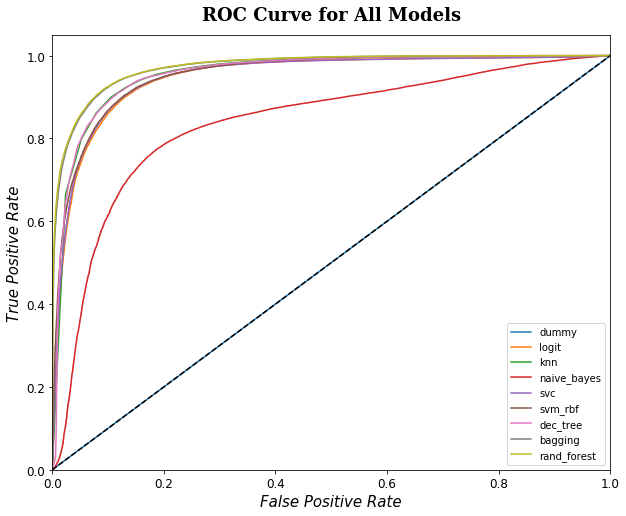

In [29]:
# plot ROC curves for all models on same plot
model_list = [dummy, logit, knn, nb, svc, rbf, tree, bag, rf]
model_names = ['dummy', 'logit', 'knn', 'naive_bayes', 'svc', 'svm_rbf', 'dec_tree', 'bagging', 'rand_forest']
fpr = {}
tpr = {}

plt.figure(figsize = (10, 8))

for ind, model in enumerate(model_list):
    # need to use scaled predictors for logistic regression, kNN, and SVM models
    if model_names[ind] in ['dummy', 'naive_bayes', 'dec_tree', 'bagging', 'rand_forest']:
        prob = model.predict_proba(X_test)[:,1]
        fpr[model_names[ind]], tpr[model_names[ind]], _ = roc_curve(y_test, prob)
        
    if model_names[ind] in ['logit', 'knn', 'svc', 'svm_rbf']:
        prob = model.predict_proba(X_te)[:,1]
        fpr[model_names[ind]], tpr[model_names[ind]], _ = roc_curve(y_test, prob)
    
    plt.plot(fpr[model_names[ind]], tpr[model_names[ind]], label = model_names[ind])

plt.title("ROC Curve for All Models", fontsize = 18, 
          fontweight = 'bold', family = 'serif', y = 1.02)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', style = 'italic', fontsize = 15)
plt.ylabel('True Positive Rate', style = 'italic', fontsize = 15)
plt.xticks(fontsize = 12, rotation = 0)
plt.yticks(fontsize = 12)
plt.legend(loc = 'lower right')

plt.savefig('ROC_all_galaxy.png', dpi = 200, bbox_inches = 'tight')
plt.show()
plt.close()

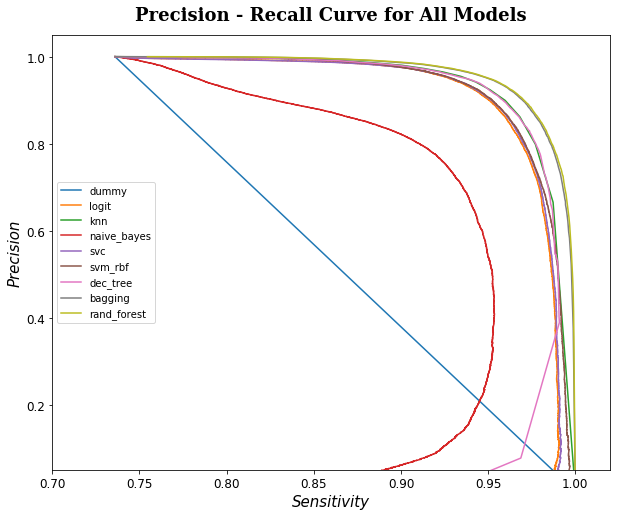

In [30]:
# plot precision-recall curves for all models on same plot
prec = {}
rec = {}

plt.figure(figsize = (10, 8))

for ind, model in enumerate(model_list):
    # need to use scaled predictors for logistic regression, kNN, and SVM models
    if model_names[ind] in ['dummy', 'naive_bayes', 'dec_tree', 'bagging', 'rand_forest']:
        prob = model.predict_proba(X_test)[:,1]
        prec[model_names[ind]], rec[model_names[ind]], _ = precision_recall_curve(y_test, prob)
        
    if model_names[ind] in ['logit', 'knn', 'svc', 'svm_rbf']:
        prob = model.predict_proba(X_te)[:,1]
        prec[model_names[ind]], rec[model_names[ind]], _ = precision_recall_curve(y_test, prob)
    
    plt.plot(prec[model_names[ind]], rec[model_names[ind]], label = model_names[ind])

plt.title("Precision - Recall Curve for All Models", fontsize = 18, 
          fontweight = 'bold', family = 'serif', y = 1.02)
plt.xlabel('Sensitivity', style = 'italic', fontsize = 15)
plt.ylabel('Precision', style = 'italic', fontsize = 15)
plt.xlim([0.70, 1.02])
plt.ylim([0.05, 1.05])
plt.xticks(fontsize = 12, rotation = 0)
plt.yticks(fontsize = 12)
plt.legend(loc = 'center left')

plt.savefig('precision_recall_all_galaxy.png', dpi = 200, bbox_inches = 'tight')
plt.show()
plt.close()

### Flask Application

In [118]:
# use redshift, u-g color, and g-r color as predictors for interactive Flask app
# astronomers commonly indicate color of object by difference between filter magnitudes (e.g. 'u-g color')
# u-g and g-r cover visible portion of spectrum and are commonly used in color-color diagrams
X_app = zsp[['redshift']]
X_app['u-g'] = zsp['u'] - zsp['g']
X_app['g-r'] = zsp['g'] - zsp['r']

# use galaxy type as response like before
y_app = zsp['spiral']
print(X_app.head(), '\n', y_app.head())

   redshift    u-g    g-r
0     0.058  1.909  0.921
1     0.084  1.653  0.772
2     0.090  1.626  0.892
3     0.054  1.806  0.988
4     0.107  1.337  0.609 
 0    0
1    1
2    1
3    1
4    1
Name: spiral, dtype: int64


In [103]:
# split train-test 50/50 with stratified sampling
X_app_train, X_app_test, y_app_train, y_app_test = train_test_split(X_app, y_app, test_size = 0.5, 
                                                    random_state = 476, stratify = y_app)

In [113]:
# fit random forest model to new predictors (training set) and evaluate with test set
# using max_features = 2 here since only 3 predictors
rf_app = RandomForestClassifier(n_estimators = 500, max_features = 2, 
                                random_state = 476, oob_score = True)
rf_app.fit(X_app_train, y_app_train)
rf_app_metrics = compute_metrics(rf_app, X_app_test, y_app_test)
rf_app_metrics

{'accuracy': 0.8522668714445938,
 'f1_score': 0.9009625349689429,
 'precision': 0.8892469380114457,
 'recall': 0.9129909531458067,
 'specificity': 0.6829595039424329,
 'log_loss': 0.36020963786091453,
 'auc': 0.9164458830320685}

In [115]:
# example user input: redshift = 0, u-g color = 0, g-r color = 0
prediction = rf_app.predict([[0, 0, 0]])[0]
prediction  # app predicts spiral galaxy

1

In [114]:
# export model as binary object for app
pickle.dump(rf_app, open('rf_app_galaxy_model.pickle', 'wb'))